In [2]:
# Imports
import shap
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from operator import itemgetter
from joblib import dump,load
shap.initjs()

# Preprocess the Data

In [3]:
# Read data
data = pd.read_csv('Dataset-Unicauca-Version2-87Atts-Clean.csv')

In [4]:
# Rename Labels to DataFlow from previous processing that bucketed data usage
data.rename({"labels": "DataFlow"}, axis=1, inplace=True)

In [5]:
# Label Protocol Names to be used as targets for Random Forest Model
lb_make = LabelEncoder()
data["labels"] = lb_make.fit_transform(data["ProtocolName"])
data[["ProtocolName", "labels"]].head(11)
mapped_label_ids = dict(zip(lb_make.classes_,range(len(lb_make.classes_))))

In [6]:
# Drop columns not needed for modelling
data.drop(columns=["Flow.ID"], inplace=True)
data.drop(columns=["ProtocolName"], inplace=True)
data.drop(columns=["L7Protocol"], inplace=True)

In [7]:
# Split Data to train/test
y = data.iloc[:, -1]
data.drop(columns=data.columns[-1], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

# Setup Visualization Labels

In [8]:
# Prepare Interactive Predictive Label Selector for Visualizations
import ipywidgets as widgets
# Create the list of all labels for the drop down list
list_of_labels = y.unique().tolist()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=mapped_label_ids,
                              value=0,
                              description='Select Label:'
                              )
# Create a widget for the labels and then display the widget
current_label2 = widgets.Dropdown(options=mapped_label_ids,
                              value=0,
                              description='Select Label:'
                              )

In [9]:
# Function to report accuracy
def print_accuracy(f):
    print("Accuracy = {0}%".format(100 * np.sum(f(X_test) == y_test) / len(y_test)))
    time.sleep(0.5)  # to let the print get out before any progress bars

# Create Simple Decision Tree Model

In [10]:
# Decision Tree Explainable
dtree = DecisionTreeClassifier(min_samples_split=20, max_depth=25)
# Need to limit depth or shap_values will crash the notebook. Accuracy is the same with depth limited
dtree.fit(X_train, y_train)
print_accuracy(dtree.predict)

Accuracy = 74.35845470047242%


# Prepare SHAP Data that Explains the Decision Tree

In [13]:
shap_sample = shap.sample(X_test, nsamples=1000)

In [14]:
# GPU Accelerated SHAP explainer
explainer = shap.explainers.GPUTree(dtree, feature_perturbation="tree_path_dependent")

In [15]:
shap_interaction_values = explainer.shap_interaction_values(shap_sample)
shap_values = explainer.shap_values(shap_sample)

# Violin Bee-Summary Plot

This is a standard violin plot but with outliers drawn as points. This gives a more accurate representation of the density out the outliers than a kernel density estimated from so few points. The color represents the average feature value at that position, so red regions have mostly high valued feature values while blue regions have mostly low feature values.

In [18]:
current_label

Dropdown(description='Select Label:', options={'99TAXI': 0, 'AMAZON': 1, 'APPLE': 2, 'APPLE_ICLOUD': 3, 'APPLE…

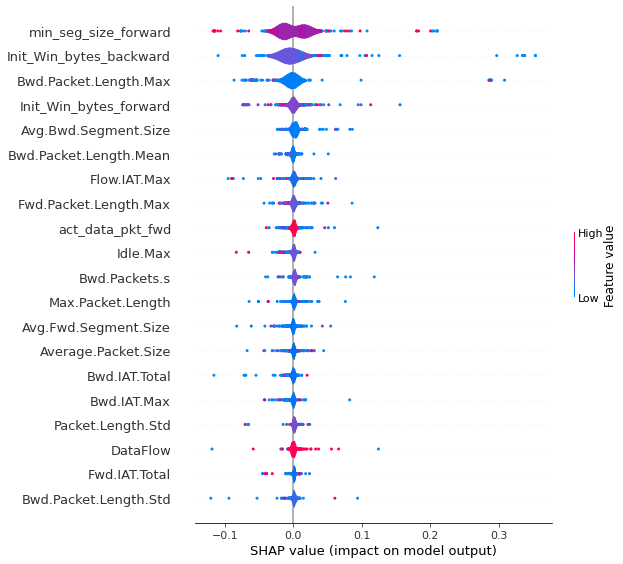

In [27]:
shap.summary_plot(shap_values = shap_values[current_label.value],
                  features = X_test.iloc[0:1000,:],
                  plot_type="violin")

By changing the label to something else we can see what features on the left have a higher impact on the model predicting this label. For example, when predicing the Protocol Name of "99TAXI" we see the feature L7Protocol has little importance on predicting this Protocol. However, the feature Forward Packet Length does.

# Stacked Importance Plot

In [20]:
current_label

Dropdown(description='Select Label:', options={'99TAXI': 0, 'AMAZON': 1, 'APPLE': 2, 'APPLE_ICLOUD': 3, 'APPLE…

In [21]:
shap.force_plot(explainer.expected_value[0], shap_values[current_label.value], shap.sample(X_test, nsamples=1000), link='logit')

Again, by changing the predicted label to something else we can see what features are significant and not significant, like from the previous visualization. However, we cal also interact with different features and compairsons from an additional labels on the top and to the left of the visualization. We can see that when both the highlighted features equal a particular value what the other features we are comparing to on top may equal.

# Visualize a Single Prediction

In [22]:
# Prepare SHAP values
test1 = shap.TreeExplainer(dtree)
t = test1.shap_values(shap.sample(X_test, nsamples=1000))

In [23]:
# See all our predicted values from our X_test dataset.
test1.expected_value

array([3.49426033e-07, 2.43850451e-02, 2.13988502e-03, 3.38593826e-04,
       3.56763979e-04, 2.79540826e-06, 2.79540826e-06, 4.89196446e-06,
       9.43450289e-06, 4.12497432e-03, 5.94024256e-06, 2.36351769e-03,
       2.06161359e-05, 4.67532032e-04, 7.03289776e-03, 2.02667099e-04,
       3.34400713e-04, 2.55081004e-05, 8.12031158e-03, 5.94024256e-06,
       7.33794669e-05, 1.12490723e-02, 2.68073363e-01, 2.27825773e-04,
       5.24139049e-06, 1.90991378e-01, 8.87846124e-02, 1.40119839e-04,
       1.74080555e-01, 6.82778468e-04, 4.56699825e-04, 6.98852066e-07,
       4.54253843e-06, 1.39770413e-06, 2.79540826e-06, 1.52849430e-02,
       8.45610999e-05, 4.04146150e-03, 6.63909462e-06, 4.89545872e-04,
       4.33637707e-04, 3.49426033e-07, 3.56414553e-05, 1.67654611e-03,
       2.44598223e-06, 6.98852066e-07, 3.84368636e-06, 1.74713016e-06,
       6.98852066e-07, 1.39770413e-06, 2.79540826e-06, 1.74713016e-06,
       2.44598223e-06, 8.59098844e-03, 1.04827810e-06, 3.49426033e-07,
      

In [24]:
# View the features that predicted this label
print("Visualization for predicted label: " + str(int(test1.expected_value[0])))
shap.force_plot(test1.expected_value[0], shap_values[76], shap.sample(X_test, nsamples=1000))

Visualization for predicted label: 0


Now interact with the dropdowns at the top to select the feature and see the values of that feature that may predict the label above.

# Non-XAI Visualization

In [25]:
# Get names of columns and importances from the model
cols = list(data.columns)
importances = dtree.feature_importances_

# Map importances to their names
feature_dict = dict(zip(cols, importances))

# Take N largest importances
N = 10
sorted_dict = dict(sorted(feature_dict.items(), key = itemgetter(1), reverse = True)[:N])
sorted_cols = list(sorted_dict.keys())
print(sorted_cols)
sorted_importances = list(sorted_dict.values())
print(sorted_importances)

['Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Fwd.Packet.Length.Max', 'min_seg_size_forward', 'URG.Flag.Count', 'Bwd.Packet.Length.Max', 'Idle.Max', 'act_data_pkt_fwd', 'Fwd.PSH.Flags', 'Fwd.Packet.Length.Std']
[0.12773822130284154, 0.11501167397853057, 0.06049804890706045, 0.05749436305193849, 0.04714657012942617, 0.041367115659310325, 0.030873881408995614, 0.029014042165836078, 0.0269660657821679, 0.022566574891321314]


<Figure size 720x720 with 0 Axes>

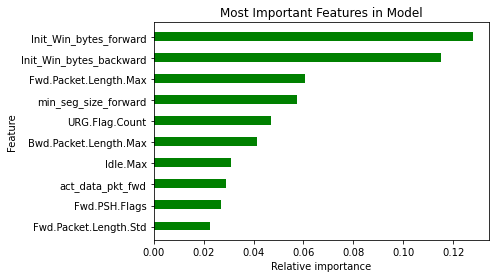

<Figure size 720x720 with 0 Axes>

In [26]:
#plot
fig, ax = plt.subplots()
width = 0.4 # the width of the bars 
ind = np.arange(len(sorted_importances)) # the x locations for the groups
ax.barh(ind, sorted_importances, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(sorted_cols, minor=False)
ax.invert_yaxis()
plt.title("Most Important Features in Model")
plt.xlabel("Relative importance")
plt.ylabel("Feature") 
plt.figure(figsize=(10,10))
# fig.set_size_inches(6.5, 4.5, forward=True)